In [9]:
# !unzip cityscapes.zip -d /aiffel/aiffel/quest_gan

Archive:  cityscapes.zip
   creating: /aiffel/aiffel/quest_gan/cityscapes/
   creating: /aiffel/aiffel/quest_gan/cityscapes/train/
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/1.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/100.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/1000.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/101.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/102.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/106.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/109.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/112.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/113.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/114.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/116.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/119.jpg  
  inflating: /aiffel/aiffel/quest_gan/cityscapes/train/12.jpg  
  inflating: /aiffel/aiffe

In [6]:
import os
import numpy as np
import tensorflow as tf
import cv2

import matplotlib.pyplot as plt
from IPython import display

### 데이터 불러오기

In [7]:
# 경로 설정, 데이터 개수 확인
path = os.getenv('HOME') + "/aiffel/quest_gan/cityscapes/"
train = path + 'train/'
val = path + 'val/'

print("number of train examples :", len(os.listdir(train)))
print("number of validation examples :", len(os.listdir(val)))

number of train examples : 1000
number of validation examples : 5


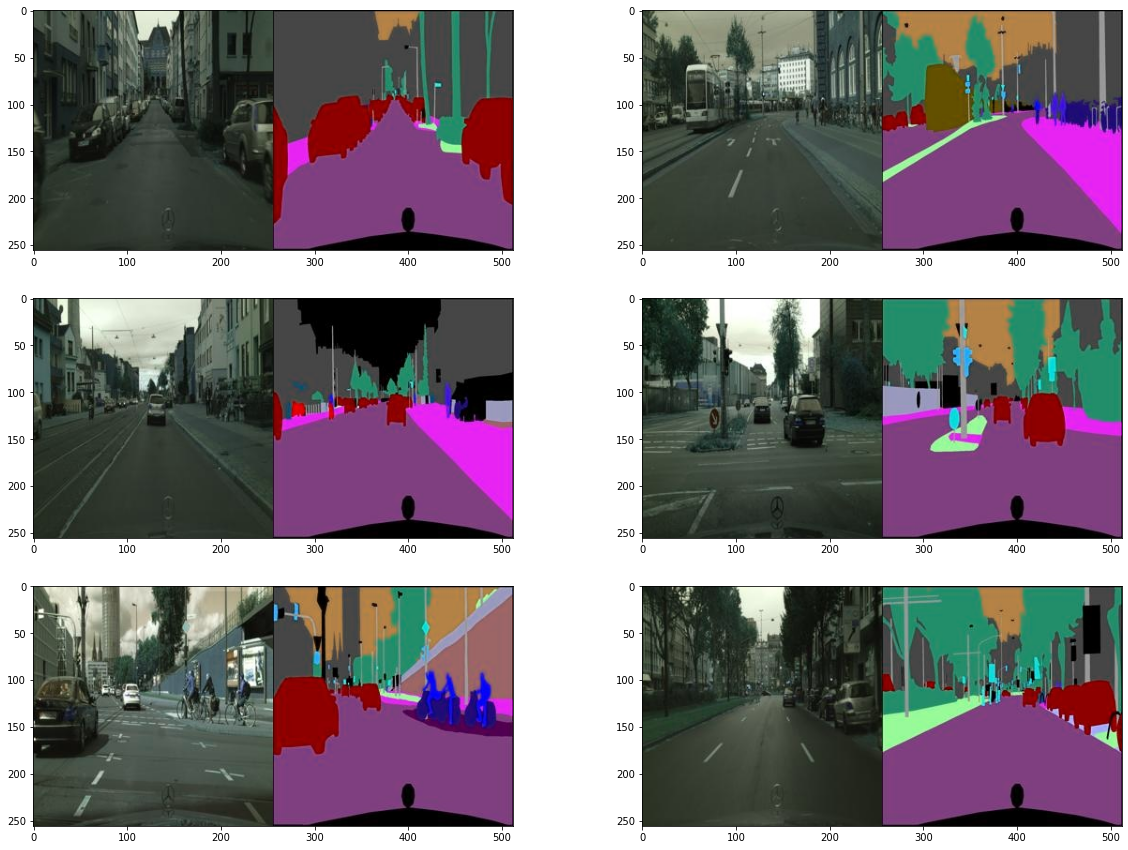

In [9]:
# 데이터 시각화
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train + os.listdir(train)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [10]:
# 데이터 shape 확인
f = train + os.listdir(train)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


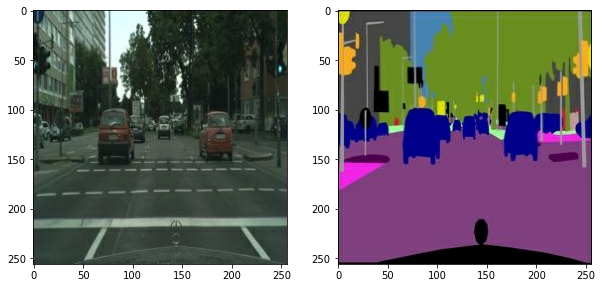

In [12]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train + os.listdir(train)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [13]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용 
def apply_augmentation(sketch, colored): 
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지를 채널 축으로 연결 
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # 50% 확률로 refection padding 혹은 constant padding이 30픽셀의 pad width만큼 적용
        padded = tf.pad(stacked, _pad, "REFLECT") # padding
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # 임의로 256, 256, 6 크기를 가진 이미지로 잘라내기
    
    out = image.random_flip_left_right(out) # 가로로 뒤집기
    out = image.random_flip_up_down(out) # 새로로 뒤집기
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 회전시키기
    
    return out[...,:3], out[...,3:]   

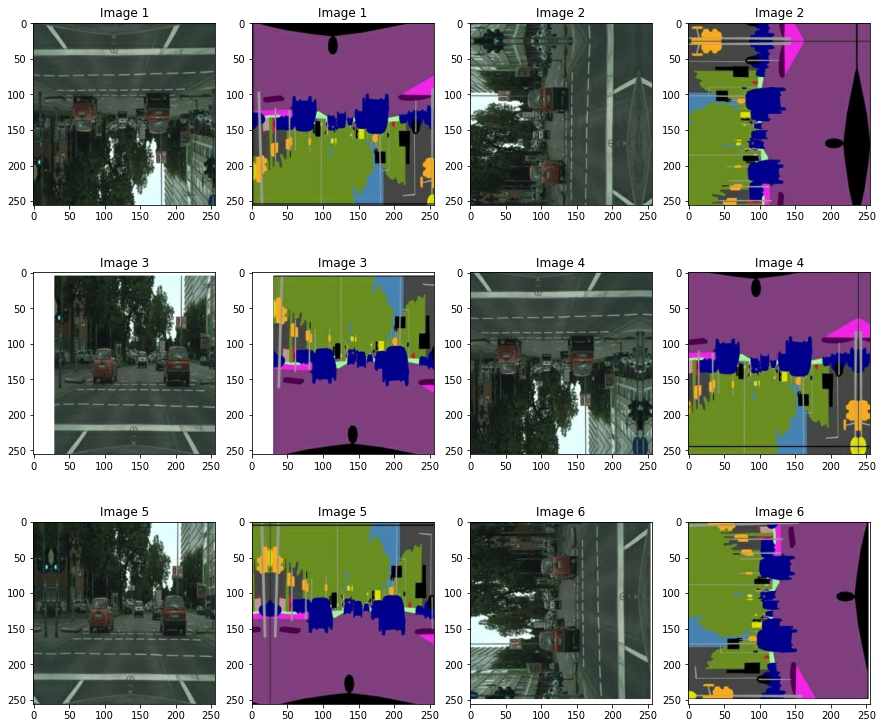

In [14]:
plt.figure(figsize=(15,13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored) # augmentation 적용한 데이터 시각화하기 
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

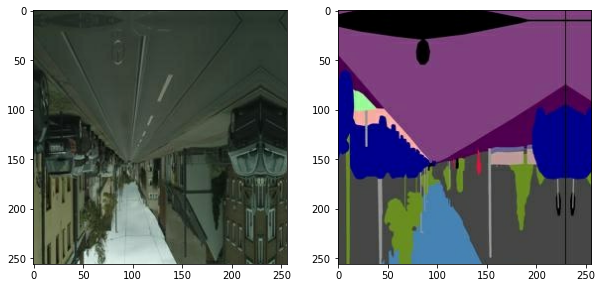

In [15]:
from tensorflow import data

def get_train(img_path): # 위의 과정을 하나로 만들기 
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구현하기

In [16]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True): # 사용할 필터의 개수와 BatchNorm 사용 여부를 결정
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False) # filter 크기 : 4, stride = 2, 
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [17]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]

        self.blocks = []
        for f in filters:
            self.blocks.append(EncodeBlock(f, use_bn = False if f == 64 else True))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
Encoder().get_summary() # 레이어 확인

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [19]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        self.blocks = []
        for i, f in enumerate(filters):
            self.blocks.append(DecodeBlock(f, dropout=True if i < 3 else False))
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [20]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [21]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [22]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

#### U-Net Generator

In [23]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # skip connection을 위해서 만듬
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [24]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [25]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act # 활성화 함수 사용 여부
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D() # width , height 양쪽 면에 각각 1씩 패딩하여 총 2만큼 크기가 늘어남
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [26]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [27]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64, 128, 256, 512, 1]
        # 첫 번째 레이어로 Concatenate를 추가합니다.
        self.concat = layers.Concatenate()
        # DiscBlock 레이어를 쌓습니다.
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                # 처음 3개 블록에서는 stride=2, custom padding과 batch normalization 사용 안 함
                self.blocks.append(DiscBlock(f, stride=2, custom_pad=False, use_bn=False))
            else:
                # 나머지 블록에서는 stride=1, custom padding 사용
                use_bn = i != 4  # 마지막 블록에서는 batch normalization 사용 안 함
                self.blocks.append(DiscBlock(f, stride=1, custom_pad=True, use_bn=use_bn))
        # 마지막에 sigmoid 활성화 함수 적용
        self.sigmoid = layers.Activation('sigmoid')
    def call(self, x, y):
        # Concatenate를 적용합니다.
        x = self.concat([x, y])
        for block in self.blocks:
            x = block(x)
        out = self.sigmoid(x)
        return out
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [28]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

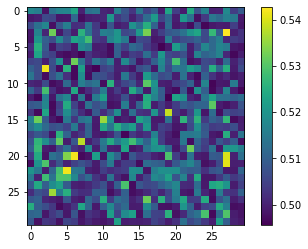

In [29]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [30]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [31]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [32]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        # Generator 예측
        fake_colored = generator(sketch, training = True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)
        # Generator 손실계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100*l1_loss) ## 
        # Discriminator 손실계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

        gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
        disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
        return gene_loss, l1_loss, disc_loss

### 모델 학습

In [33]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.6704                     
L1_loss:0.3215                     
Discriminator_loss:1.0856

EPOCH[1] - STEP[20]                     
Generator_loss:0.6872                     
L1_loss:0.3425                     
Discriminator_loss:1.2402

EPOCH[1] - STEP[30]                     
Generator_loss:0.7599                     
L1_loss:0.2812                     
Discriminator_loss:0.9250

EPOCH[1] - STEP[40]                     
Generator_loss:0.7445                     
L1_loss:0.2709                     
Discriminator_loss:0.9370

EPOCH[1] - STEP[50]                     
Generator_loss:0.6293                     
L1_loss:0.2887                     
Discriminator_loss:1.0549

EPOCH[1] - STEP[60]                     
Generator_loss:0.7577                     
L1_loss:0.2388                     
Discriminator_loss:0.9741

EPOCH[1] - STEP[70]                     
Generator_loss:0.8328                     
L1_loss:0.2281                    

### validation 결과 확인

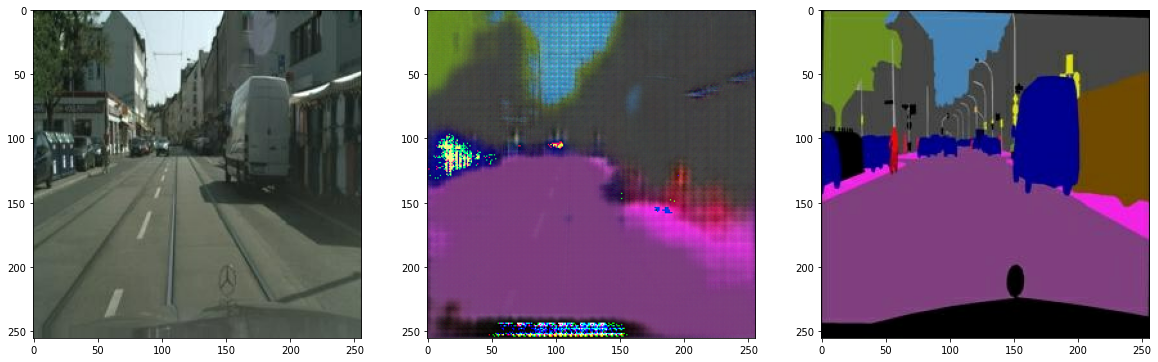

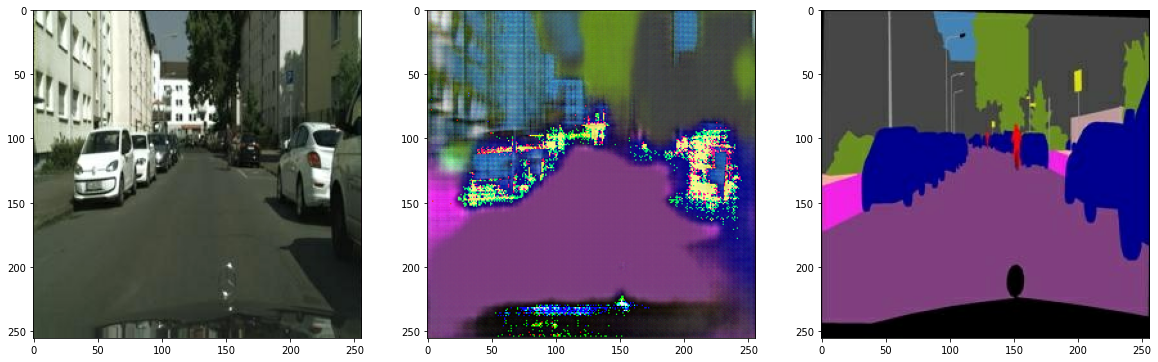

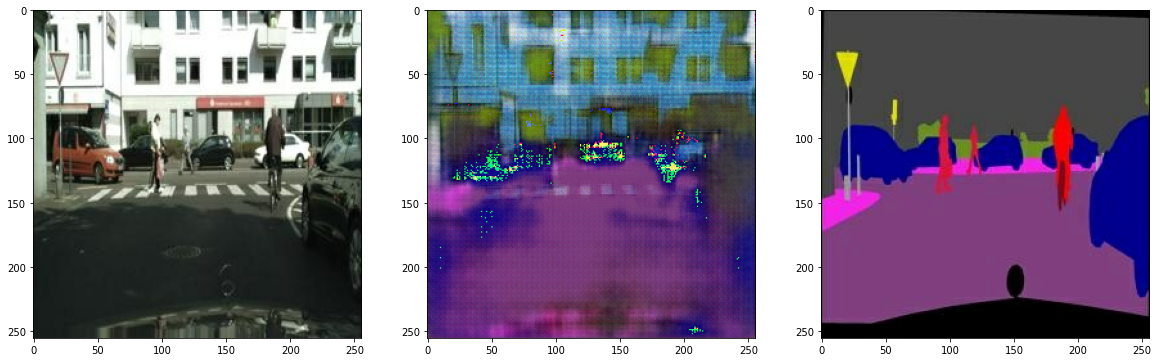

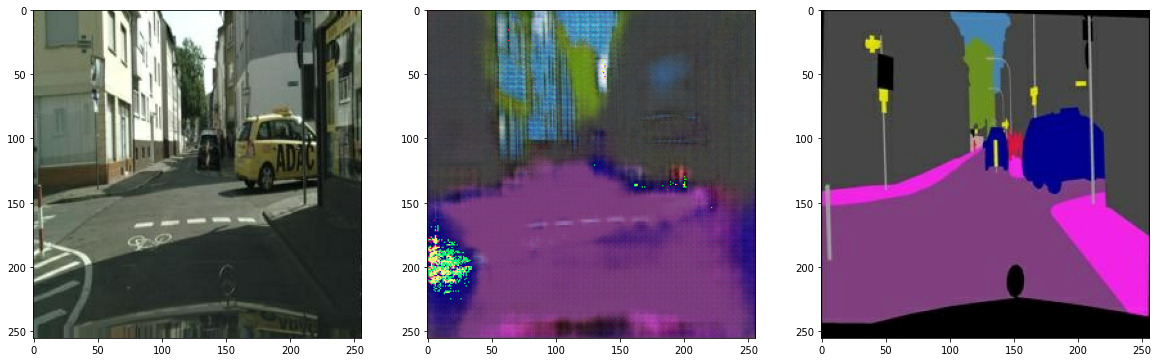

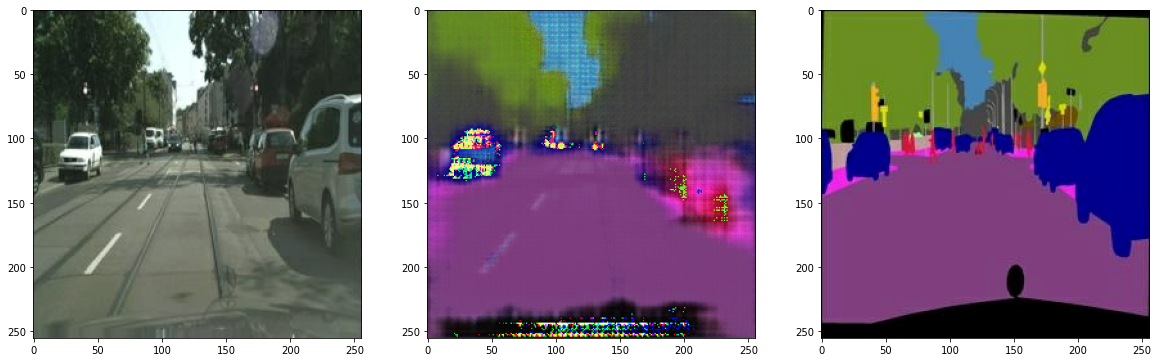

In [37]:
test_ind = 1

for i in range(len(os.listdir(val))):
    f = val + os.listdir(val)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 회고

* 많이 부족함을 느꼈고, 갈 길이 멀다는 것을 느끼게 한 퀘스트였다.
* 시간을 많이 들여서 차근차근 내 것으로 만들어야겠다고 다짐하게 되었다.